## **라이브러리 다운로드 및 불러오기**

In [ ]:
## 라이브러리 다운로드

# 통계
!pip3 install numpy scipy patsy pandas

# 한글깨짐 해결('코드 실행' → '런타임' → '세션 다시시작' 실행)
!pip install matplotlib -U
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 워드클라우드
!pip install nltk
!pip install wordcloud
!pip install konlpy

# 연관성분석
!pip install apyori

# LDA
!pip install gensim

In [ ]:
## 라이브러리 불러오기

# 데이터 핸들링
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import re
import csv

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # plot "-" 부호 표기 설정

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# 통계
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from apyori import apriori
import networkx as nx

# NLP
import nltk
from wordcloud import WordCloud
from nltk import Text
import nltk
from nltk import FreqDist
import gensim
from gensim import *
from gensim import corpora, models
from gensim import models
from gensim.models import LdaModel
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim import utils
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

# 경고 안내 무시
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 200)       # row 출력제한 해제
pd.set_option('display.max_columns', 100)   # column 출력제한 해제

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **데이터**

In [ ]:
# 데이터 불러오기
MDunpa_df05 = pd.read_csv('/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Fianl_Review_Dataset_05.csv')
del MDunpa_df05["Unnamed: 0"]

# 데이터 확인
print(MDunpa_df05.shape)
MDunpa_df05.tail()

(10653, 21)


,리뷰_ID,고객_ID,평점,평점극성,감성점수,감성극성,유용성,(원본)리뷰어,(정제)리뷰어,품사(빈도),품사(감성),작성일자,년,월,일,Binary,filtering,감정,cluster_03,cluster_04,cluster_05
10648,11662,ᄌᄒ,1,부정,0,중립,1,1주년이 뭔 주는게 저번 레압뿌리는거만도못함 그리고 오즈마 횟수는 왜갑자기 증발하는...,주년이 뭔 주는 게 저번레 압뿌리는 거만도 못함 그리고 오즈마 횟수는 왜 갑자기 증...,"['주년', '게', '저번', '레', '압', '거만', '오즈', '마', '...","['주년', '주는', '저번', '뿌리는', '거만', '오즈', '횟수', '갑...",2023-04-04,2023,4,4,After,일치,혐오,0,0,0
10649,11663,YU k,3,중립,0,중립,1,사람이 너무 많이 줄었음;; '그 국가'에 정식출시하는 것 말곤 답이 없는 듯,사람이 너무 많이 줄었음 그 국가에 정식 출시하는 것 말곤답이 없는 듯,"['사람', '그', '국가', '정식', '출시', '것', '답', '듯']","['사람', '너무', '많이', '줄었음', '국가', '정식', '출시', '하...",2023-04-04,2023,4,4,After,일치,중립,0,0,0
10650,11664,장정현,1,부정,-1,부정,1,생각이 있다면 버서커 너프좀 하시길,생각이 있다면 버서 커너프 좀 하시길,"['생각', '버', '너프', '좀']","['생각', '있다면', '너프', '하시길']",2023-04-04,2023,4,4,After,일치,혐오,0,0,0
10651,11665,Eddie park,3,중립,3,긍정,1,오래전 피던에대한 추억 향수으로 잘하고 있지만 이벤트도 너무 숙제같아지고 있고 신규...,오래전 피던 에 대한 추억 향수으로 잘하고 있지만 이벤트도 너무 숙제 같아지고 있고...,"['대한', '추억', '향수', '로', '이벤트', '숙제', '신규', '케릭...","['오래전', '피던', '대한', '추억', '향수', '하고', '있지만', '...",2023-04-05,2023,4,5,After,일치,슬픔,0,0,0
10652,11666,롤롤,5,긍정,0,중립,0,아라드격투왕 터치안되는버그 빨리 고쳐주시고 접속하면 아이템 없다고 뜨는 버그 고쳐줘요,아라드격투왕 터치 안 되는 버그빨리 고쳐주시고 접속하면 아이템 없다고 뜨는 버그 고쳐줘요,"['아라드', '격투', '터치', '안', '버그', '접속', '아이템', '버그']","['아라드', '격투', '터치', '되는', '버그', '빨리', '고쳐주시고',...",2023-04-05,2023,4,5,After,일치,중립,0,0,0


## **속성분석(토픽모델링 LDA)**

### **최적의 토픽 수(k) 측정**

In [ ]:
# 4개 품사를 기반으로 입력값 생성

insert_data = pd.DataFrame(MDunpa_df05, columns=["품사(감성)"])                                      # 데이터프레임 재정의(4개 품사에 대한 토큰)

empty_list = []
for i in range(0, len(insert_data)):
    preproseing01 = str(str(str(insert_data["품사(감성)"][i]).split("[")[1]).split("]")[0])          # 지난 과정에서 "명사" 추출 변수 정제
    preproseing02 = re.sub(r'[\'\"]', '',preproseing01)                                              # 특수문자 제거
    preproseing03 = re.sub(r'\s+', '', preproseing02).split(",")                                     # 공백 제거
    empty_list.append(preproseing03)

In [ ]:
  # 입력값 형태 변환
dictionary = corpora.Dictionary(empty_list)                   # 토큰사전 구축(토큰화)
print(dictionary); print()

corpus = [dictionary.doc2bow(text) for text in empty_list]    # 말뭉치 구축(벡터화)
print('corpus : {}'.format(corpus)); print()

Dictionary<14412 unique tokens: ['다년', '돌아올지', '설레면서', '설치', '했던']...>

corpus : [[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(29, 1), (38, 1)], [(38, 1), (39, 1), (40, 1), (41, 1), (42, 1)], [(26, 1), (38, 1), (43, 1), (44, 1), (45, 1), (46, 1)], [(9, 1), (47, 1)], [(31, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1)], [(71, 1), (72, 1)], [(73, 1), (74, 1), (75, 1)], [(42, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1)], [(31, 1), (81, 1), (82, 1)], [(83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1)], [(4, 1), (31, 1),

In [ ]:
# LDA 모델 구축 & 최적의 토픽 수 측정

# LDA 하이퍼 파라미터 설정
iterations = 1000
random_num = 100
alphas = i/50
etas = 0.01
passes = 15
eval_every = 1
chunksize = 100
alphas = i/50


# 성과 측정을 위한 리스트 구축(일관성, 혼잡도)
galexy_coherence_score=[]
galexy_Perplexity_score=[]
topics_list = [2, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

for i in tqdm(topics_list):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, passes=passes, iterations=iterations, random_state=random_num, alpha=alphas, eta=etas)
    Perplexity = model.log_perplexity(corpus)                                                               # 성과 측정(혼잡도)

    coherence_model = CoherenceModel(model, texts = empty_list, dictionary = dictionary, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()                                                         # 성과 측정(일관성)

    print(); print('k =',i,'혼잡도(Perplexity): ', round(Perplexity, 2))
    galexy_Perplexity_score.append(Perplexity)

    print('k =',i,'일관성(Coherence) : ', round(coherence_lda, 2))
    galexy_coherence_score.append(coherence_lda)

  9%|▉         | 1/11 [00:14<02:20, 14.09s/it]


k = 2 혼잡도(Perplexity):  -32.29
k = 2 일관성(Coherence) :  0.51


 18%|█▊        | 2/11 [00:31<02:26, 16.29s/it]


k = 20 혼잡도(Perplexity):  -35.03
k = 20 일관성(Coherence) :  0.41


 27%|██▋       | 3/11 [00:55<02:37, 19.72s/it]


k = 40 혼잡도(Perplexity):  -36.04
k = 40 일관성(Coherence) :  0.38


 36%|███▋      | 4/11 [01:24<02:43, 23.35s/it]


k = 60 혼잡도(Perplexity):  -37.13
k = 60 일관성(Coherence) :  0.39


 45%|████▌     | 5/11 [02:00<02:47, 27.87s/it]


k = 80 혼잡도(Perplexity):  -40.96
k = 80 일관성(Coherence) :  0.39


 55%|█████▍    | 6/11 [02:44<02:46, 33.23s/it]


k = 100 혼잡도(Perplexity):  -42.47
k = 100 일관성(Coherence) :  0.39


 64%|██████▎   | 7/11 [03:43<02:47, 41.77s/it]


k = 120 혼잡도(Perplexity):  -42.62
k = 120 일관성(Coherence) :  0.38


 73%|███████▎  | 8/11 [04:50<02:29, 49.88s/it]


k = 140 혼잡도(Perplexity):  -43.69
k = 140 일관성(Coherence) :  0.39


 82%|████████▏ | 9/11 [06:04<01:54, 57.42s/it]


k = 160 혼잡도(Perplexity):  -45.29
k = 160 일관성(Coherence) :  0.38


 91%|█████████ | 10/11 [07:21<01:03, 63.40s/it]


k = 180 혼잡도(Perplexity):  -46.73
k = 180 일관성(Coherence) :  0.39


100%|██████████| 11/11 [08:46<00:00, 47.87s/it]


k = 200 혼잡도(Perplexity):  -47.39
k = 200 일관성(Coherence) :  0.38


In [ ]:
## 함수 생성

# 차트 옵션 정의
def plot_option01(title_name, input_data01, input_data02):
    plt.rc('font', family='NanumBarunGothic')                      # 폰트
    plt.rcParams["figure.figsize"] = (12,4)                        # 차트 크기
    plt.rcParams['lines.linewidth'] = 0.8                          # 선 굵기
    plt.rcParams['lines.color'] = 'k'                              # 선 색상
    plt.title(title_name, fontsize=12, fontweight='bold')          # 차트 제목
    plt.xticks(size = 10, fontweight ="bold")                      # x축 크기 및 굵기
    plt.xlabel('토픽 수', fontweight='bold')                       # x축 제목
    plt.xlim(2, 200)                                               # x축 범위
    plt.yticks(size = 10, fontweight ="bold")                      # y축 크기 및 굵기
    plt.ylabel('일관성 수치', fontweight='bold')                   # y축 제목
    plt.plot(input_data01, input_data02, linestyle='-', color='k')
    plt.grid(True)

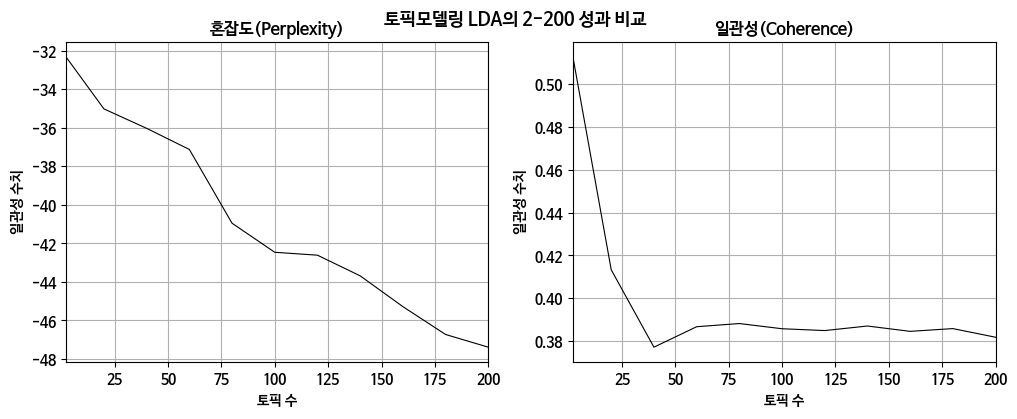

In [ ]:
# 시각화
x_array = np.array(topics_list)
y_Perp = np.array(galexy_Perplexity_score)
y_coher = np.array(galexy_coherence_score)

plt.suptitle('토픽모델링 LDA의 2-200 성과 비교', fontsize=13, fontweight ="bold")

plt.subplot(1, 2, 1)
plot_option01("혼잡도(Perplexity)", x_array, y_Perp)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(1, 2, 2)
plot_option01("일관성(Coherence)", x_array, y_coher)
plt.show()

In [ ]:
# 혼잡도(Perplexity)는 작은 값일수록, 일관성(Coherence)은 큰 값일수록 최적의 k값이라 판단할 수 있으며, 상기 차트를 통해 최적의 토픽 수(k) '60'을 확인했다.

___

### **토픽 추출**

In [ ]:
## 속성분석(토픽모델링 LDA)
# ①입력값 전처리--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

print("토픽모델링 LDA: ①입력값 전처리")
tem_token_list = []       # 불용어사전으로 제거된 토픽 리스트(1)
empty_list_new = []       # 불용어사전으로 제거된 토픽 리스트(2)

# 불용어사전 구축
kor_stopwords = ["생각", "사전", "계속", "진짜", "다시", "그냥", "하라",  "다른", "정말", "정도", "시작", "하나", "만큼", "역시", "처음", "지금", "건가", "해도", "확인",'썼는데',  "때문", "자꾸", "조금", '초창',
                 "아주", "해당", "일단", "무슨", "하니", "부분", "이상", "이후", "오늘", "수가", "추가", "바로", "보고", "이건", "이번", "요즘", '사용',  "이제", "수라", "가지", "뭔가", "발아", "거의", '그런지',
                 "중이", "가요", "경우", "그때", "차이", '없나요', '없음', '했다고', '있네요', '하네요', '여러', '나오면','자사',  '들어', '하며', '모르고', '없이', '있어요', '뜨는데', '나네요', '만하', '보네',
                 '하는',  '했는데', '하려고', '해주세요', '되어', '갑자기', '있어', '나오고', '나게', '너무나',  '주는', '합니다', '하겠습니다', '심합니다', '오면', '해서', '거임', '아니고', '없고', '만든',
                 '아닌', '아무리', '싶은데', '해보고', '되게', '되요', '하기', '있어서', '하루',  '했으면', '해야', '주세요', '쓰는데', '되고', '있는데', '않네요', '잇는', '되네요', '떠서', '이나', '누르면',
                 '입니다', '쉽고', '있습니다', '되다가', '하고', '만들었음', '돋고', '눌러도', '눌렸는데', '도대체', '금방', '있나' '너무', '했습니다', '재밌음', '메카', '필요', '했었는데', '받은', '뜨고',
                 '같은', '하고', '싶다', '건지', '즐길', '있고', '나와서', '하던', '파는', '있는', '나은', '하면', '너무', '그렇게', '이긴', '돋네요', '크리', '같아', '됩니다', '하면', '집니다', '해보세요',
                 '아직', '너무', '하나요', '받고', '그대로', '다르게', '할려니', '해봤는데', '세라', '된다', '그렇고', '모든', '거기', '해보는데', '하세요', '않습니다', '하세요', '하고', '나왔다고', '하면',
                 '하냐', '되었습니다', '입니다', '되는', '않음', '하는데', '않고', '되면', '한다', '않는', '너무', '있었는데', '봐야', '같은', '처럼', '하지', '나와', '한번', '바랍니다', '하니까', '없으면',
                 '있나요', '입니다', '만들었네요', '뜨는', '했던', '로서', '있는', '없어요', '아예', '하면', '', '없네요', '관련', '될까', '있지', '하다가', '할려고', '하러', '있네', '됩니다', '같습니다',
                 '하면', '되는', '건지', '같아요', '나고', '나왔다',  '걸까', '없다고', '되는데', '보이네요', '지워', '정이', '하게', '없는', '인지', '나오는데', '없는', '들이', '갑니다', '되니', '데던', '크게',
                 '아니라', '없는', '잇어요', '토리', '지네', '만해', '이렇게', '했다가', '기존', '했지만', '있게', '아닌가', '하려', '있음', '받아', '같은데', '없어', '사는', '되네', '이면', '나옴', '남아',
                 '비해', '근데', '있다고', '걸리고', '있음', '그나마', '해볼게요','그거','같은데', '먹고', '가능하게', '하죠', '많이', '해놓고', '치는', '팔이', '보이', '좋고', '받을', '이렇게', '나온', '개심',
                 '있었으면', '하다', '싶어요', '깔고', '깔았는데', '어쩌', '나올', '됐는데', '있도록', '플립', '심하게', '거나', '했을', '떠오르네요', '없어서', '마라', '그게', '해보니', '싶네요', '떠요',
                 '나왔으면', '아닌데', '많아서', '받나요', '넘게', '이럴', '해보는', '많은', '뜨면서', '봐요', '되는지', '요하', '되서', '봅니다', '보다', '없습니다', '하자', '나오네', '있던', '만이', '별개',
                 '나오는', '맞는', '꺼면', '나오니', '이미', '돼요', '않은', '들어가', '이리', '하래', '저리', '줘요', '그러는', '위해','면서', '대로', '같아서', '했음', '뭐임', '까요', '했네', '슈시', '참고',
                 '되나', '한다고', '똑같네요', '가네요', '보이지', '그럴', '점점', '해주시길', '확실히', '했고', '같고', '잇습니다', '똑바로', '없다', '놓고', '있지만', '돈슨', '없네', '한참', '해봐야', '시대',
                 '했는', '점도', '프리', '시도', '주고', '다가', '아직도', '상당히', '걸리는', '지우고', '아니라고', '파이', '솔직히', '나머지', '만들', '있긴', '보니', '없지만', '누가', '그리', '해줬으면',
                 '깔아도', '해볼', '성도', '지웠다', '아님', '되는데요', '특히', '자체', '그런', '다운', '하다니', '않아', '가는', '했다', '뜨네요', '있을', '오지', '겁니다', '듭니', '오고', '겁나', '안주나요',
                 '들어가서', '로만', '뜹니다', '일시', '는데', '나서', '되지', '없는데', '했는데도', '먹을', '된다고', '보입니다', '받는', '아닌가요', '했네요', '해주시면', '안됨',  '하구', '거지', '마세요',
                 '이따', '왔는데', '잘만', '삭제', '요한', '되었네요', '금도', '받아서', '사실', '해야지', '있다는', '아니냐', '가볍게', '따로', '달라', '잡고', '놓은', '되나요', '불가',  '할만', '고요', '개인',
                 '도도', '기다린', '하네', '하신', '가능', '시키는', '걸려', '나을', '없나','젖어', '년도', '납니다', '심해서', '였는데', '없다는', '원래', '모르겠지만', '전혀','주셔서', '모르겠다', '드립니다',
                 '들어가면', '대한', '더욱', '완성', '받으면', '월일', '문구', '말들었네', '오나요', '기는', '할게요', '드디어', '꾸준히', '그것', '유지', '런가', '심한', '별로','하기가', '남은', '돋는', '이유',
                 '나름', '어릴', '믿고', '년전', '굿굿', '제일', '같음', '돼는', '오랜', '돼는', '인생', '기다리고', '감사합니다', '최근', '바뀐', '빠져', '나오네요', '원하는','보면', '성은', '뭐라','오래',
                 '걸리네', '클릭', '할게요', '맞게', '해주세', '같네요', '초반', '나오게', '해본', '이러면', '들어서', '끄고', '있으면', '만들어', '먹는',  '없을', '시킨', '데이터', '같네', '괜히', '분명', '하려는']

# 불용어사전 단어 수
kor_stopwords = list(set(kor_stopwords))
print('- 불용어 단어 수: ', len(kor_stopwords));print()

# LDA모델 학습 전, 불용어사전의 단어를 활용하여 전처리
for i in tqdm(range(0, len(empty_list))) :
    for j in range(0, len(empty_list[i])):
        Word_text = empty_list[i][j]

        if Word_text not in kor_stopwords :
            tem_token_list.append(Word_text)  # 필터링
        else :
            pass
    empty_list_new.append(tem_token_list)
    tem_token_list = []

dictionary = corpora.Dictionary(empty_list_new)                  # 토근화
corpus = [dictionary.doc2bow(text) for text in empty_list_new]   # 말뭉치 생성


# ②LDA모델 학습---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("토픽모델링 LDA: ②LDA모델 학습"); print()
fianl_keywords = []   # LDA모델의 토픽 수에 따른 최종 토큰 리스트
fianl_number   = []   # LDA토픽 수 리스트
save_keywords  = []   # 토큰 저장용 리스트

# LDA모델에 최적의 토픽 수 60 적용
model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = 60, id2word = dictionary, passes = passes, iterations = iterations, random_state = random_num, alpha =alphas, eta=etas)
topics = model.print_topics(num_words=20)


# ③ 결과 출력-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("토픽모델링 LDA: ③ 결과 출력")
fianl_keywords = []   # LDA모델의 토픽 수에 따른 최종 토큰 리스트
fianl_number   = []   # LDA토픽 수 리스트
save_keywords  = []   # 토큰 저장용 리스트
Print_number = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]  # 출력값: 20개

print("- 토픽 출력")
for q in tqdm(range(0, len(topics))) :
    # 토픽 인덱스
    fianl_number.append(topics[q][0])

    # 토픽 결과
    for i in Print_number :
        save_keywords.append(topics[q][1].split('"')[i]) # 임시저장 리스트
    fianl_keywords.append(save_keywords)                 # 최종 출력 결과를 저장하는 리스트(임시저장 리스트)
    save_keywords = []                                   # 임시저장 리스트(초기화)

print()
j = 0
for a in fianl_number:
    print(str(a) + str(fianl_keywords[j])); print()
    j = j + 1

토픽모델링 LDA: ①입력값 전처리
- 불용어 단어 수:  514



100%|██████████| 10653/10653 [00:00<00:00, 15106.96it/s]


토픽모델링 LDA: ②LDA모델 학습

토픽모델링 LDA: ③ 결과 출력
- 토픽 출력


100%|██████████| 20/20 [00:00<00:00, 14760.88it/s]


5['아수라', '게임', '추억', '버전', '쿠폰', '보상', '최고', '이벤트', '모바일', '버튼', '강제', '패치', '캐시', '아쉽네요', '옛날', '재미있네요', '이해', '감도', '인원', '유저']

41['소통', '컨텐츠', '게임', '던전', '패치', '제발', '모바일', '변경', '진행', '보드', '좋은데', '컴퓨터', '옛날', '인증', '스마트폰', '해결', '느껴', '과금', '던파', '추억']

23['게임', '패치', '로그인', '온라인', '레압', '입장', '던파', '피씨', '캐릭터', '이동', '재밋', '차단', '새록새록', '느낌', '현질', '좋아요', '유저', '업데이트', '모바일', '설치']

50['버그', '게임', '재밌게', '리뷰', '케릭', '유저', '실행', '모바일', '모드', '기분', '조작', '양산', '접속', '사람', '최적화', '재미있어요', '계정', '핸드폰', '기억', '동시']

59['게임', '친구', '광고', '추천', '전체', '피로', '추억', '던파', '문자', '생기', '다운로드', '업데이트', '등록', '스토리', '재미', '접속', '갤럭시', '모바일', '마음', '사냥']

25['게임', '밸런스', '버그', '평가', '모바일', '플레이', '던파', '추억', '캐릭', '업데이트', '피시', '유저', '스킬', '로딩', '입력', '번호', '결장', '부탁드립니다', '힘드네요', '좋습니다']

16['결장', '게임', '레벨', '현상', '좋겠어요', '유저', '재미있습니다', '즐기고', '버전', '캐릭', '오류', '빨리', '플레이', '상점', '등록', '추억', '서버', '스킬', '현재', '좋아요']

24['초기', '공격', '패드', '게임', '제발', '빨리', '생각나서', '결장', '요소', '핸드폰', '적당한', 

In [ ]:
## 속성별 대표단어 구축

# 1. 핵심 속성단어: 던파 모바일 플레이와 직접적으로 관련된 단어
Key_Attribute = ['케릭', '게임', '던파', '결장', '스킬', '캐쉬', '쿠폰', '사람', '공중', '사냥', '캐릭터', '아바타',
                 '플레이', '사용자', '자동', '컨텐츠', '모드', '유저', '피로', '계정', '쿠폰', '닉네임', '타격']

# 2. 주변 속성단어: 던파 모바일 플레이와 간접적(포괄적)으로 관련 단어
Around_Attribute = ['접속', '네트워크', '모바일', '핸드폰', '조작', '인터넷', '유입', '업데이트', '제한', '혜택',
                    '리뷰', '과금', '접속', '서비스', '매크로', '점검', '연결', '지원', '운영', '접속', '해외',
                    '충전', '보상', '신청', '현질', '버그', '컴퓨터', '개발', '연동', '튕기', '패치', '업뎃',
                    '동의', '소통', '패치', '설명', '다운로드', '예약', '수정', '진행', '문의', '사양', '설치',
                    '서버', '접속', '개편', '출시', '마켓']

# 3. 정서 속성단어: 던파 모바일 플레이 이후, 고객이 느끼는 감정 관련 단어
senti_Attribute = ['최고', '재미있네요', '추억', '옛날', '개꿀잼', '좋겠다', '반응', '생각나고', '재미있게', '재미있는',
                   '경험', '느낄', '느낌', '좋네요', '접음', '재미', '향수', '좋아요', '새롭네요', '좋습니다', '좋네요',
                   '최신', '즐겁게', '간만', '예전', '불안정하다고', '감성', '괜찮은데', '새록새록', '기대', '옛날',
                   '잼나요', '재밌습니다', '즐기고', '아깝다', '비슷하게', '힘들어요', '응원', '빠른', '최악', '격감',
                   '재밌게', '재밌다', '생각나네', '빠르고', '잼나네요']

In [ ]:
# 상기에서 토픽모델링 LDA모델을 통해 추출한 단어들을 3개 게임 속성에 매칭하여 대표단어 사전을 구축했다.
# 이에, 사전을 활용하여 리뷰 데이터별 평점을 속성 가중치로 재측정하여 속성 평점을 생성했다.

---

In [ ]:
# 데이터 불러오기
MDunpa_df05 = pd.read_csv('/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Fianl_Review_Dataset_05.csv')
del MDunpa_df05["Unnamed: 0"]

# 데이터 확인
print(MDunpa_df05.shape)
MDunpa_df05.tail()

(10653, 21)


,리뷰_ID,고객_ID,평점,평점극성,감성점수,감성극성,유용성,(원본)리뷰어,(정제)리뷰어,품사(빈도),품사(감성),작성일자,년,월,일,Binary,filtering,감정,cluster_03,cluster_04,cluster_05
10648,11662,ᄌᄒ,1,부정,0,중립,1,1주년이 뭔 주는게 저번 레압뿌리는거만도못함 그리고 오즈마 횟수는 왜갑자기 증발하는...,주년이 뭔 주는 게 저번레 압뿌리는 거만도 못함 그리고 오즈마 횟수는 왜 갑자기 증...,"['주년', '게', '저번', '레', '압', '거만', '오즈', '마', '...","['주년', '주는', '저번', '뿌리는', '거만', '오즈', '횟수', '갑...",2023-04-04,2023,4,4,After,일치,혐오,0,0,0
10649,11663,YU k,3,중립,0,중립,1,사람이 너무 많이 줄었음;; '그 국가'에 정식출시하는 것 말곤 답이 없는 듯,사람이 너무 많이 줄었음 그 국가에 정식 출시하는 것 말곤답이 없는 듯,"['사람', '그', '국가', '정식', '출시', '것', '답', '듯']","['사람', '너무', '많이', '줄었음', '국가', '정식', '출시', '하...",2023-04-04,2023,4,4,After,일치,중립,0,0,0
10650,11664,장정현,1,부정,-1,부정,1,생각이 있다면 버서커 너프좀 하시길,생각이 있다면 버서 커너프 좀 하시길,"['생각', '버', '너프', '좀']","['생각', '있다면', '너프', '하시길']",2023-04-04,2023,4,4,After,일치,혐오,0,0,0
10651,11665,Eddie park,3,중립,3,긍정,1,오래전 피던에대한 추억 향수으로 잘하고 있지만 이벤트도 너무 숙제같아지고 있고 신규...,오래전 피던 에 대한 추억 향수으로 잘하고 있지만 이벤트도 너무 숙제 같아지고 있고...,"['대한', '추억', '향수', '로', '이벤트', '숙제', '신규', '케릭...","['오래전', '피던', '대한', '추억', '향수', '하고', '있지만', '...",2023-04-05,2023,4,5,After,일치,슬픔,0,0,0
10652,11666,롤롤,5,긍정,0,중립,0,아라드격투왕 터치안되는버그 빨리 고쳐주시고 접속하면 아이템 없다고 뜨는 버그 고쳐줘요,아라드격투왕 터치 안 되는 버그빨리 고쳐주시고 접속하면 아이템 없다고 뜨는 버그 고쳐줘요,"['아라드', '격투', '터치', '안', '버그', '접속', '아이템', '버그']","['아라드', '격투', '터치', '되는', '버그', '빨리', '고쳐주시고',...",2023-04-05,2023,4,5,After,일치,중립,0,0,0


In [ ]:
# 4개 품사를 기반으로 입력값 생성

empty_list = []
for i in range(0, len(insert_data)):
    preproseing01 = str(str(str(MDunpa_df05["품사(감성)"][i]).split("[")[1]).split("]")[0])              # 지난 과정에서 "명사" 추출 변수 정제
    preproseing02 = re.sub(r'[\'\"]', '',preproseing01)                                                  # 특수문자 제거
    preproseing03 = re.sub(r'\s+', '', preproseing02).split(",")                                         # 공백 제거
    empty_list.append(preproseing03)

In [ ]:
# 생성된 리스트 확인
print(len(empty_list))
print(empty_list[0])
print(empty_list[0][0]); print()

# 평점 데이터 확인
print(len(MDunpa_df05["평점"]))
print(MDunpa_df05["평점"][0]); print()
star_ratio = MDunpa_df05["평점"]

# 리뷰 번호 확인
print(len(MDunpa_df05["리뷰_ID"]))
print(MDunpa_df05["리뷰_ID"][0])
review_ID = MDunpa_df05["리뷰_ID"]

10653
['설치', '다년', '설레면서', '했던', '돌아올지']
설치

10653
5

10653
0


In [ ]:
# 속성별 단어 체크 변수

final_data_list = []                                                               # 최종 측정된 변수들을 모아서 정리할 리스트
Key_word_list = []; Around_word_list = []; senti_word_list = []                    # 속성별 단어를 수집할 리스트

for one_list_number in tqdm(range(0, len(empty_list))):

  # 단어를 체크할 변수 정의
  Key_word = 0; Around_word = 0; senti_word = 0; total_count = 0
  Key_star_num = 0; Around_star_num = 0; senti_star_num = 0

  ## 전체 리스트에서 1개 리스트를 넘기면,
  # 예시) ['설치', '다년', '설레면서', '했던', '돌아올지']
  one_list           = empty_list[one_list_number]
  one_list_star      = star_ratio[one_list_number]
  one_list_review_id = review_ID[one_list_number]

  for one_list_word in one_list:                                                  # 넘겨받은 리스트의 한개 단어를 체크
    if one_list_word in Key_Attribute:                                            # '핵심 속성단어'가 포함되었는지 여부 확인
      Key_word    += 1                                                            # (핵심 사전의 단어가 포함될 경우) 핵심 단어/전체단어 카운트 +1
      Key_word_list.append(one_list_word)
      total_count += 1
    elif one_list_word in Around_Attribute:                                       # '주변 속성단어'가 포함되었는지 여부 확인
      Around_word += 1
      Around_word_list.append(one_list_word)
      total_count += 1
    elif one_list_word in senti_Attribute:                                        # '감성 속성단어'가 포함되었는지 여부 확인
      senti_word  += 1
      senti_word_list.append(one_list_word)
      total_count += 1

  if total_count == 0:
    Key_star_num = 0
    Around_star_num = 0
    senti_star_num = 0
  else:
    # 평점을 속성별 단어를 기반으로 세분화
    Key_star_num    = one_list_star * (Key_word/total_count)
    Around_star_num = one_list_star * (Around_word/total_count)
    senti_star_num  = one_list_star * (senti_word/total_count)

  final_data_list.append([one_list_review_id, total_count, one_list_star,         # 리뷰ID, 총카운트수, 리뷰평점
                          Key_word, Key_word_list, Key_star_num,                  # 핵심 카운트수, 핵심 카운트단어, 핵심 평점
                          Around_word, Around_word_list, Around_star_num,         # 주변 카운트수, 주변 카운트단어, 주변 평점
                          senti_word, senti_word_list, senti_star_num])           # 감성 카운트수, 감성 카운트단어, 감성 평점
  Key_word_list = []; Around_word_list = []; senti_word_list = []                 # 반복을 위해 리스트 초기화

print("리뷰의 속성별 단어 갯수 : ", end = ''); print(len(final_data_list))
print("리뷰의 속셩별 단어(예제): ", end = ''); print(final_data_list[0])

100%|██████████| 10653/10653 [00:00<00:00, 26327.33it/s]

리뷰의 속성별 단어 갯수 : 10653
리뷰의 속셩별 단어(예제): [0, 1, 5, 0, [], 0.0, 1, ['설치'], 5.0, 0, [], 0.0]


In [ ]:
# 데이터 백업: 측정한 속성별 세부평점
with open('/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Attribute_Detailed_Straing.csv', 'w', encoding='utf-8',  newline="") as f:
  writer = csv.writer(f)
  writer.writerow(['리뷰_ID', '총카운트수', '평점', '핵심카운트수', '핵심카운트단어', '핵심평점', '주변카운트수', '주변카운트단어', '주변평점', '감성카운트수', '감성카운트단어', '감성평점'])
  for u in final_data_list:
    writer.writerow(u)

In [ ]:
# 데이터 확인
Attribute_Detailed_Straing = pd.read_csv("/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Attribute_Detailed_Straing.csv")
print(Attribute_Detailed_Straing.shape)
Attribute_Detailed_Straing.head()

(10653, 12)


,리뷰_ID,총카운트수,평점,핵심카운트수,핵심카운트단어,핵심평점,주변카운트수,주변카운트단어,주변평점,감성카운트수,감성카운트단어,감성평점
0,0,1,5,0,[],0.0000,1,['설치'],5.0000,0,[],0.0000
1,1,0,5,0,[],0.0000,0,[],0.0000,0,[],0.0000
2,2,2,5,0,[],0.0000,0,[],0.0000,2,"['느낌', '향수']",5.0000
3,3,1,5,0,[],0.0000,0,[],0.0000,1,['추억'],5.0000
4,4,1,5,1,['게임'],5.0000,0,[],0.0000,0,[],0.0000


In [ ]:
MDunpa_df05["핵심평점(속01)"] = Attribute_Detailed_Straing["핵심평점"]
MDunpa_df05["주변평점(속02)"] = Attribute_Detailed_Straing["주변평점"]
MDunpa_df05["감성평점(속03)"] = Attribute_Detailed_Straing["감성평점"]

In [ ]:
MDunpa_df05.head()

,리뷰_ID,고객_ID,평점,평점극성,감성점수,감성극성,유용성,(원본)리뷰어,(정제)리뷰어,품사(빈도),품사(감성),작성일자,년,월,일,Binary,filtering,감정,cluster_03,cluster_04,cluster_05,핵심평점(속01),주변평점(속02),감성평점(속03)
0,0,잘들어라 쫌,5,긍정,0,중립,0,설치한다. 15년전 내가 설레면서 했던 그 갬성이 돌아올지,설치한 다년 전 내가 설레면서 했던 그 갬성이 돌아올지,"['설치', '다년', '전', '내', '그', '성']","['설치', '다년', '설레면서', '했던', '돌아올지']",2022-03-22,2022,3,22,Befor,일치,슬픔,0,0,0,0.0000,5.0000,0.0000
1,1,Minghao Huang,5,긍정,1,긍정,0,"기대하다,드디어 나왓네요.별점5개박고 즐겜시작해보겠습니다.",기대하다 드디어 나왓네 요별점 개박고 즐겜 시작해보겠습니다,"['나왓', '점', '개', '즐겜', '시작']","['기대하다', '드디어', '나왓', '박고', '즐겜', '시작', '해보겠습니다']",2022-03-22,2022,3,22,Befor,일치,행복,0,0,0,0.0000,0.0000,0.0000
2,2,노리,5,긍정,2,긍정,0,더도 안바란다. 과거 느낌만 잘 표현해서 향수만 느끼게 해주면 성공한거다...pc던...,더 도안 바란다 과거 느낌만 잘 표현해서 향수만 느끼게 해주면 성공한 거다 PC던 ...,"['더', '도안', '과거', '느낌', '표현', '향수', '거', '던', ...","['도안', '바란다', '과거', '느낌', '표현', '해서', '향수', '느...",2022-03-22,2022,3,22,Befor,일치,혐오,0,0,0,0.0000,0.0000,5.0000
3,3,이우영,5,긍정,0,중립,89,오 기대됩니다 완전 던파 브금.노래등등 추억자극,오기대됩니다 완전던 파브금 노래 등 등 추억 자극,"['오기', '완전', '던', '파', '브금', '노래', '등', '등', '...","['오기', '됩니다', '완전', '브금', '노래', '추억', '자극']",2022-03-22,2022,3,22,Befor,일치,행복,2,3,4,0.0000,0.0000,5.0000
4,4,리즈유나이티드,5,긍정,0,중립,0,"게임성, 과금 모델까지 두루 갖춘 명작",게임성과 금 모델까지 두루 갖춘 명작,"['게임', '성과', '금', '모델', '두루', '명작']","['게임', '성과', '모델', '두루', '갖춘', '명작']",2022-03-22,2022,3,22,Befor,일치,행복,0,0,0,5.0000,0.0000,0.0000


In [ ]:
#MDunpa_df05.to_csv("/content/drive/MyDrive/3. Research/[기업] 분석 과제/네오플 트렌드 분석/Data/Fianl_Review_Dataset_06.csv")

___